In [1]:
# sctour environment (make sure scikit-misc is also installed)
# from https://sctour.readthedocs.io/en/latest/notebook/scTour_inference_basic.html
import sctour as sct
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
adata = sc.read('/Users/kevinlin/Dropbox/Collaboration-and-People/yenchi-jerry_yuhong/data/EX_development_human_cortex_10X.h5ad')
adata.shape

(36318, 19073)

In [3]:
adata

AnnData object with n_obs × n_vars = 36318 × 19073
    obs: 'Sample ID', 'Sample age', 'Sample batch', 'Seurat cluster', 'RNA count', 'RNA features', 'Fraction MT', 'Fraction Ribo', 'Cell barcode', 'DF_pANN', 'DF_classification', 'DF_pANN_quantile', 'VC_Spliced.Counts', 'VC_Spliced.Features', 'VC_Unspliced.Counts', 'VC_Unspliced.Features', 'VC_Ambiguous.Counts', 'VC_Ambiguous.Features', 'Name', 'Name (long)', 'In GluN trajectory', 'Color', 'Order', 'N cells', 'celltype'
    var: 'n_cells'
    uns: 'celltype_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'

In [4]:
adata.obs['celltype'][0:9]

Cell ID
hft_w20_p3_r1_AAACCCACATAGTCAC    MigN
hft_w20_p3_r1_AAACCCAGTACAGGTG    MigN
hft_w20_p3_r1_AAACCCAGTACGGTTT    MigN
hft_w20_p3_r1_AAACCCAGTATGTCCA    MigN
hft_w20_p3_r1_AAACCCAGTTGCTCAA    MigN
hft_w20_p3_r1_AAACCCATCTGCAGCG    MigN
hft_w20_p3_r1_AAACCCATCTGTCAGA    nIPC
hft_w20_p3_r1_AAACGAAAGATGAAGG    MigN
hft_w20_p3_r1_AAACGAACAGACCATT    MigN
Name: celltype, dtype: category
Categories (5, object): ['CycP', 'nIPC', 'MigN', 'ImmN', 'MatN']

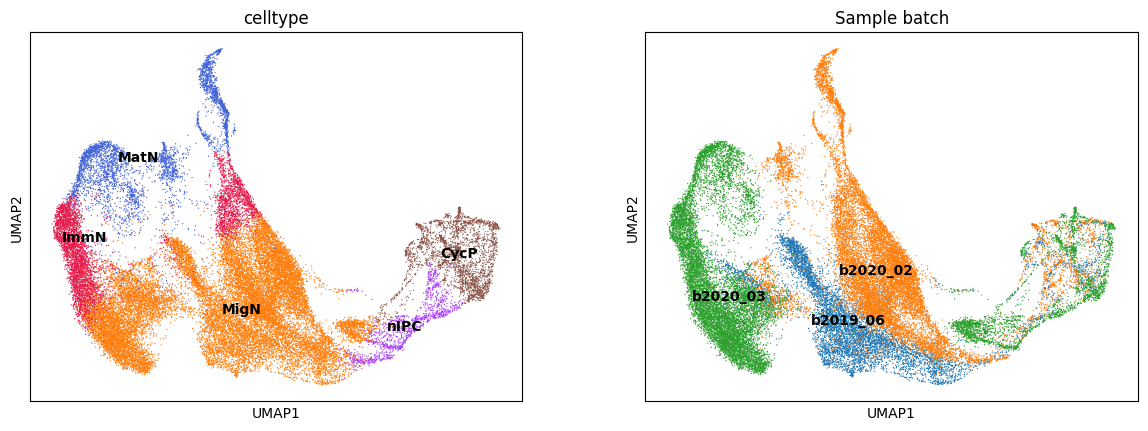

In [5]:
sc.pl.umap(adata, color=['celltype', 'Sample batch'], legend_loc='on data')

In [6]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [7]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=1000, subset=True)

In [8]:
tnode = sct.train.Trainer(adata, 
                          loss_mode='nb', 
                          alpha_recon_lec=0.5, 
                          alpha_recon_lode=0.5)
tnode.train()

Running using CPU.
Epoch 400: 100%|██████████| 400/400 [07:14<00:00,  1.09s/epoch, train_loss=269, val_loss=265]


In [9]:
adata.obs['ptime'] = tnode.get_time()

In [10]:
#zs represents the latent z from variational inference, and pred_zs represents the latent z from ODE solver
#mix_zs represents the weighted combination of the two, which is used for downstream analysis
mix_zs, zs, pred_zs = tnode.get_latentsp(alpha_z=0.5, alpha_predz=0.5)
adata.obsm['X_TNODE'] = mix_zs

In [11]:
adata.obsm['X_VF'] = tnode.get_vector_field(adata.obs['ptime'].values, adata.obsm['X_TNODE'])

In [12]:
# adata = adata[np.argsort(adata.obs['ptime'].values), :]
sc.pp.neighbors(adata, use_rep='X_TNODE', n_neighbors=15)
sc.tl.umap(adata, min_dist=0.1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/miniconda3/envs/sctour/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/opt/miniconda3/envs/sctour/lib/python3.9/site-packages/sctour/vector_field.py:109: RuntimeWarning: invalid value encountered in divide
  cos_sim = np.einsum("ij, j", dZ, V[i]) / (l2_norm(dZ, axis = 1) * l2_norm(V[i]))


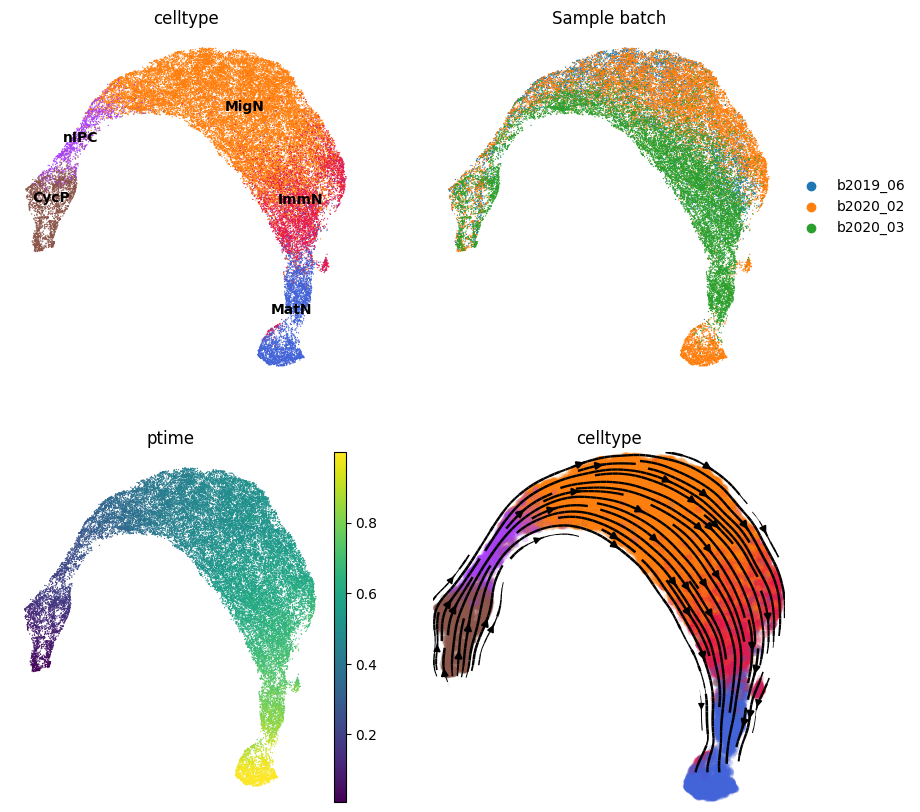

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
sc.pl.umap(adata, color='celltype', ax=axs[0, 0], legend_loc='on data', show=False, frameon=False)
sc.pl.umap(adata, color='Sample batch', ax=axs[0, 1], show=False, frameon=False)
sc.pl.umap(adata, color='ptime', ax=axs[1, 0], show=False, frameon=False)
sct.vf.plot_vector_field(adata, zs_key='X_TNODE', vf_key='X_VF', use_rep_neigh='X_TNODE', color='celltype', show=False, ax=axs[1, 1], legend_loc='none', frameon=False, size=100, alpha=0.2)
plt.show()

Saving results

In [14]:
tnode

In [57]:
# This line is used to save the trained model
tnode.save_model(save_dir="/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/yenchi-jerry_yuhong/out/veloUncertainty/kevin/Writeup1",
                 save_prefix="sctour_tutorial")

In [16]:
adata.write("/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/yenchi-jerry_yuhong/out/veloUncertainty/kevin/Writeup1/Writeup1_sctour.h5ad")

Trying to pass things into the encoder manually

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
import torch

In [18]:
tnode.model.encoder

Encoder(
  (fc): Sequential(
    (L1): Linear(in_features=1000, out_features=128, bias=True)
    (A1): ReLU()
  )
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

In [19]:
adata

AnnData object with n_obs × n_vars = 36318 × 1000
    obs: 'Sample ID', 'Sample age', 'Sample batch', 'Seurat cluster', 'RNA count', 'RNA features', 'Fraction MT', 'Fraction Ribo', 'Cell barcode', 'DF_pANN', 'DF_classification', 'DF_pANN_quantile', 'VC_Spliced.Counts', 'VC_Spliced.Features', 'VC_Unspliced.Counts', 'VC_Unspliced.Features', 'VC_Ambiguous.Counts', 'VC_Ambiguous.Features', 'Name', 'Name (long)', 'In GluN trajectory', 'Color', 'Order', 'N cells', 'celltype', 'n_genes_by_counts', 'total_counts', 'ptime'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'celltype_colors', 'hvg', 'neighbors', 'pca', 'umap', 'Sample batch_colors'
    obsm: 'X_pca', 'X_umap', 'X_TNODE', 'X_VF', 'X_DV'
    obsp: 'distances', 'connectivities', 'cosine_similarity'

In [20]:
X_tmp = adata.X[0:5,].copy()
print(X_tmp.shape)

(5, 1000)


In [21]:
adata.X[0:5,0:5]

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [22]:
X_tmp

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [23]:
X = np.log1p(adata.X)

In [24]:

sparse.issparse(X)

False

In [25]:
tnode.model.eval()
X = torch.tensor(X).to(tnode.model.device)
tmp, _, _ = tnode.model.encoder(X)
tmp = tmp.ravel()
print(tmp)


tensor([0.5383, 0.6797, 0.6201,  ..., 0.3235, 0.5375, 0.6131],
       grad_fn=<ViewBackward0>)


In [26]:
tmp[0:100] # there's a sort going on????

tensor([0.5383, 0.6797, 0.6201, 0.5758, 0.3300, 0.6076, 0.2389, 0.3088, 0.4593,
        0.5837, 0.4922, 0.0482, 0.4802, 0.3176, 0.5952, 0.3332, 0.3250, 0.4102,
        0.4846, 0.1619, 0.4911, 0.5783, 0.4980, 0.4009, 0.5955, 0.4982, 0.4216,
        0.2715, 0.5702, 0.5064, 0.6094, 0.5792, 0.2683, 0.5124, 0.5798, 0.5652,
        0.4018, 0.4801, 0.4904, 0.4390, 0.4892, 0.1428, 0.7506, 0.3174, 0.5410,
        0.4403, 0.4623, 0.5733, 0.5512, 0.5088, 0.5286, 0.1784, 0.5616, 0.3571,
        0.5659, 0.0390, 0.3309, 0.4987, 0.4102, 0.0515, 0.1589, 0.4737, 0.6103,
        0.6007, 0.6272, 0.5373, 0.4095, 0.6515, 0.1187, 0.1481, 0.4337, 0.1987,
        0.3983, 0.4587, 0.4421, 0.4269, 0.5904, 0.6080, 0.4104, 0.3945, 0.2369,
        0.4244, 0.1619, 0.5612, 0.4284, 0.4411, 0.4117, 0.5492, 0.2707, 0.2071,
        0.3701, 0.4707, 0.4722, 0.4290, 0.4274, 0.4554, 0.0735, 0.4192, 0.5053,
        0.3918], grad_fn=<SliceBackward0>)

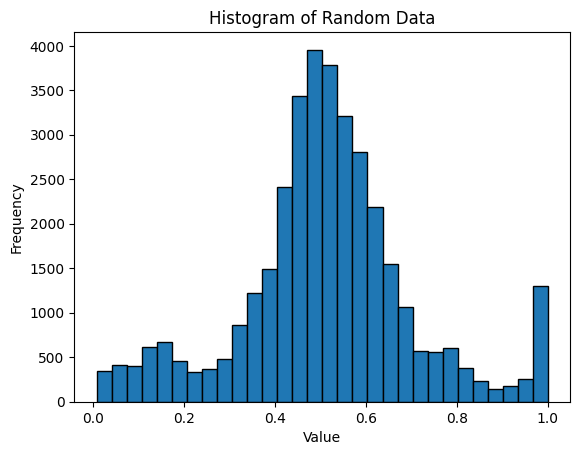

In [27]:
plt.hist(tmp.detach().numpy(), bins=30, edgecolor='black')  # bins specify the number of bins in the histogram
plt.title('Histogram of Random Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [28]:
zz = tnode.get_time()
print(zz[0:10])
print(zz.shape)
print(zz[0:100])


[0.5383383  0.6797158  0.62013817 0.5758147  0.32995716 0.60760754
 0.23893583 0.30883437 0.45933238 0.58374935]
(36318,)
[0.5383383  0.6797158  0.62013817 0.5758147  0.32995716 0.60760754
 0.23893583 0.30883437 0.45933238 0.58374935 0.49219024 0.0481912
 0.48015535 0.3175858  0.59523386 0.33323807 0.3249623  0.41020468
 0.48464143 0.16187768 0.49113837 0.57828003 0.49795124 0.40087283
 0.5955066  0.49819776 0.42156333 0.2715159  0.5702478  0.506404
 0.60943633 0.5791859  0.26833746 0.51240176 0.579769   0.5652115
 0.40175125 0.4801149  0.49043489 0.4390256  0.48920858 0.14280578
 0.7506301  0.31744736 0.54103136 0.44034642 0.4622762  0.5733482
 0.5511604  0.5088176  0.52855635 0.17838901 0.5615559  0.357054
 0.5658597  0.0390086  0.3308847  0.49867883 0.41020012 0.05149081
 0.15893652 0.47372624 0.6103109  0.60065    0.62716866 0.5372936
 0.40951893 0.6514606  0.11868897 0.14809057 0.4336799  0.19871265
 0.39828408 0.45874494 0.4421307  0.42686832 0.590385   0.6080434
 0.4103815  0.39

In [29]:
tnode.adata.X[0:5,0:5]

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

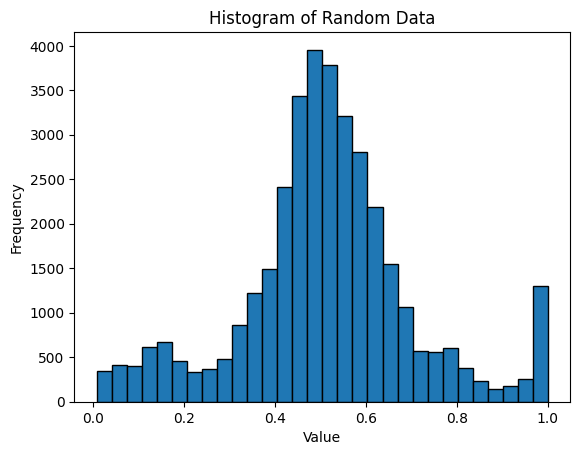

In [30]:
plt.hist(zz, bins=30, edgecolor='black')  # bins specify the number of bins in the histogram
plt.title('Histogram of Random Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [31]:
# Create a 2D array
array_2d = np.array([[1, 2, 3], [4, 5, 6]])

# Flatten the array using ravel()
array_flat = array_2d.ravel()
print(array_2d)
print(array_flat)

[[1 2 3]
 [4 5 6]]
[1 2 3 4 5 6]


In [32]:
adata.obs['ptime'][0:100]

Cell ID
hft_w20_p3_r1_AAACCCACATAGTCAC    0.538338
hft_w20_p3_r1_AAACCCAGTACAGGTG    0.679716
hft_w20_p3_r1_AAACCCAGTACGGTTT    0.620138
hft_w20_p3_r1_AAACCCAGTATGTCCA    0.575815
hft_w20_p3_r1_AAACCCAGTTGCTCAA    0.329957
                                    ...   
hft_w20_p3_r1_AACCTTTTCGACCTAA    0.455443
hft_w20_p3_r1_AACGAAAAGAGGATGA    0.073518
hft_w20_p3_r1_AACGAAACAGTAGGAC    0.419199
hft_w20_p3_r1_AACGAAACATCTGCGG    0.505348
hft_w20_p3_r1_AACGGGAAGAGTCGAC    0.391762
Name: ptime, Length: 100, dtype: float32

Playing around with torchdiffeq's odeint

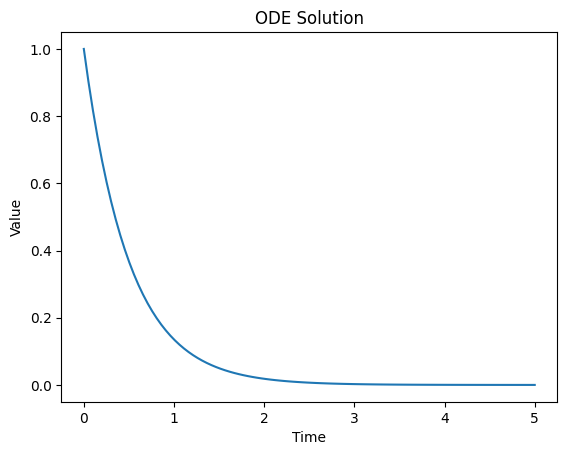

In [33]:
import torch
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Define the ODE function
def func(t, y):
    return -2 * y

# Initial condition
y0 = torch.tensor([1.0])

# Time points
t = torch.linspace(0, 5, 100)

# Solve the ODE
solution = odeint(func, y0, t)

# Plot the solution
plt.plot(t.numpy(), solution.numpy())
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ODE Solution')
plt.show()


In [34]:
solution

tensor([[1.0000e+00],
        [9.0392e-01],
        [8.1708e-01],
        [7.3858e-01],
        [6.6762e-01],
        [6.0348e-01],
        [5.4550e-01],
        [4.9309e-01],
        [4.4571e-01],
        [4.0289e-01],
        [3.6418e-01],
        [3.2919e-01],
        [2.9757e-01],
        [2.6898e-01],
        [2.4313e-01],
        [2.1977e-01],
        [1.9866e-01],
        [1.7957e-01],
        [1.6232e-01],
        [1.4673e-01],
        [1.3263e-01],
        [1.1989e-01],
        [1.0837e-01],
        [9.7956e-02],
        [8.8545e-02],
        [8.0038e-02],
        [7.2348e-02],
        [6.5397e-02],
        [5.9114e-02],
        [5.3435e-02],
        [4.8301e-02],
        [4.3660e-02],
        [3.9466e-02],
        [3.5674e-02],
        [3.2247e-02],
        [2.9148e-02],
        [2.6348e-02],
        [2.3817e-02],
        [2.1528e-02],
        [1.9460e-02],
        [1.7590e-02],
        [1.5900e-02],
        [1.4373e-02],
        [1.2992e-02],
        [1.1744e-02],
        [1

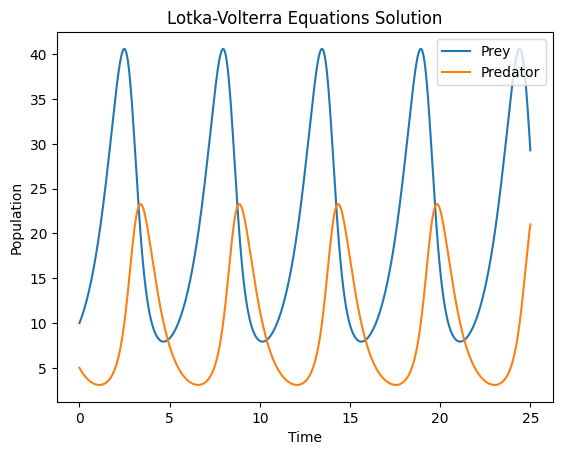

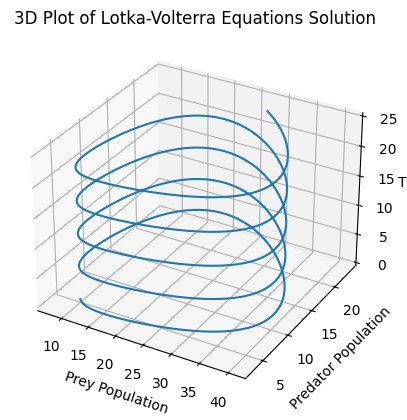

In [36]:
import torch
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the ODE function
def lotka_volterra(t, state):
    x, y = state[0], state[1]
    alpha, beta, gamma, delta = 1.0, 0.1, 1.5, 0.075
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return torch.tensor([dxdt, dydt])

# Initial conditions
state0 = torch.tensor([10.0, 5.0])

# Time points
t = torch.linspace(0, 25, 1000)

# Solve the ODE
solution = odeint(lotka_volterra, state0, t)

# Extract the solution
x = solution[:, 0].detach().numpy()
y = solution[:, 1].detach().numpy()
t = t.detach().numpy()

# Plot the solution in 2D
plt.figure()
plt.plot(t, x, label='Prey')
plt.plot(t, y, label='Predator')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.title('Lotka-Volterra Equations Solution')
plt.show()

# Plot the solution in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, t, label='Population Dynamics')
ax.set_xlabel('Prey Population')
ax.set_ylabel('Predator Population')
ax.set_zlabel('Time')
plt.title('3D Plot of Lotka-Volterra Equations Solution')
plt.show()


Let's give it a try now

In [37]:
X = np.log1p(adata.X)
tnode.model.eval()
X = torch.tensor(X).to(tnode.model.device)
pseudtotime, posterior_mean, _ = tnode.model.encoder(X)
pseudtotime = pseudtotime.ravel()


In [38]:
print(pseudtotime)
print(posterior_mean)

tensor([0.5383, 0.6797, 0.6201,  ..., 0.3235, 0.5375, 0.6131],
       grad_fn=<ViewBackward0>)
tensor([[-0.5803,  0.1830,  0.2539,  0.4906, -0.0018],
        [-0.3205,  0.3283,  0.6075,  1.3765, -0.1163],
        [-0.7300,  0.4444,  0.1463,  1.1162, -0.1556],
        ...,
        [-0.7654,  0.1733,  0.3443, -1.1665, -0.0031],
        [-0.3893,  0.0117,  1.0306,  0.1328, -0.0420],
        [ 0.0620, -0.1666,  0.7940,  0.4821,  0.0185]],
       grad_fn=<SliceBackward0>)


In [41]:
quantiles = [0, 0.25, 0.5, 0.75, 1]
np.percentile(pseudtotime.detach().numpy(), [q * 100 for q in quantiles])

array([0.00822418, 0.42558967, 0.51023078, 0.60275856, 0.99999809])

In [62]:
pseudtotime[0]

tensor(0.5383, grad_fn=<SelectBackward0>)

In [63]:
T =  torch.tensor([pseudtotime[0], pseudtotime[0]+1/100])
print(T)

tensor([0.5383, 0.5483])


In [59]:
options = {}
res_simple = odeint(tnode.model.lode_func, 
             posterior_mean[0,:].to('cpu'), 
             T.to('cpu'), 
             method = tnode.model.ode_method, 
             options = options).view(-1, tnode.model.n_latent)

In [60]:
print(res_simple.shape)
print(type(res_simple))
print(res_simple[0])

torch.Size([2, 5])
<class 'torch.Tensor'>
tensor([-0.5803,  0.1830,  0.2539,  0.4906, -0.0018],
       grad_fn=<SelectBackward0>)


In [61]:
res_simple

tensor([[-0.5803,  0.1830,  0.2539,  0.4906, -0.0018],
        [-0.5492,  0.1654,  0.2569,  0.5494, -0.0010]],
       grad_fn=<ViewBackward0>)

In [64]:
vec1 = tnode.model.decoder(res_simple[0])
vec2 = tnode.model.decoder(res_simple[1])

print(vec2-vec1)

tensor([ 2.6959e-05, -3.5277e-06, -4.0224e-06,  1.8235e-06,  3.6037e-05,
         3.9078e-05,  3.0583e-04, -1.9694e-06,  2.0334e-07, -3.1441e-07,
        -5.7331e-07, -1.0953e-08, -6.4804e-07, -1.5964e-04, -1.9000e-05,
        -1.3035e-05,  3.1151e-06, -3.1618e-06,  3.6510e-06,  2.9959e-07,
         2.9588e-07, -4.3363e-07, -2.0085e-07, -3.1072e-06, -9.5089e-06,
        -2.8761e-06,  2.2810e-04, -5.6841e-04, -4.2591e-04, -8.3308e-06,
        -9.7435e-06,  1.2813e-06, -1.3551e-06, -2.8557e-06,  4.9507e-07,
        -5.3793e-07, -2.7896e-05, -3.6856e-05, -9.7941e-06, -1.3792e-04,
        -1.9897e-07,  8.9712e-06,  1.5063e-05,  3.0643e-05, -4.1650e-07,
        -1.3381e-06, -1.2753e-05, -3.6417e-05, -2.1341e-05, -5.5182e-07,
        -8.2550e-07, -5.4343e-06, -7.4336e-07, -2.3948e-06, -1.1223e-06,
        -2.9731e-05, -5.8315e-07, -3.6216e-07, -2.6760e-07, -1.9219e-05,
        -5.3184e-06, -1.8765e-05, -1.9837e-05,  1.7890e-09, -3.8290e-06,
         1.8984e-08, -2.9923e-05, -1.1151e-06, -5.6

In [53]:
def compute_velocity(tnode, timestep=1/100):
    X = tnode.adata.X
    X = np.log1p(adata.X)

    tnode.model.eval()
    X = torch.tensor(X).to(tnode.model.device)

    pseudtotime, posterior_mean, _ = tnode.model.encoder(X)
    differences = []

    for i in range(len(pseudtotime)):
        # Define T for the current pseudotime
        T = torch.tensor([pseudtotime[i], pseudtotime[i] + timestep])
        
        # Compute the ODE solutions
        res = odeint(tnode.model.lode_func, 
                     posterior_mean[i,:].to('cpu'), 
                     T.to('cpu'), 
                     method = tnode.model.ode_method).view(-1, tnode.model.n_latent)
        
        # Decode the ODE solutions
        vec1 = tnode.model.decoder(res[0])
        vec2 = tnode.model.decoder(res[1])
        
        # Compute the difference and append to the list
        differences.append((vec2 - vec1).detach().numpy())

    # Convert the list of differences to a numpy array
    differences_matrix = np.array(differences)
    return differences_matrix

In [54]:
res = compute_velocity(tnode)

In [55]:
res.shape

(36318, 1000)

In [56]:
res[0:5,0:5]

array([[ 2.69589946e-05, -3.52771167e-06, -4.02238220e-06,
         1.82347321e-06,  3.60367412e-05],
       [ 2.31356826e-05, -1.27052226e-06,  6.11740688e-07,
         3.51496055e-06,  6.84557017e-05],
       [ 1.06457155e-05, -2.93537596e-06, -6.08306436e-07,
         2.80020504e-06,  4.49665822e-05],
       [ 2.53778417e-05, -3.14060162e-06, -3.01731779e-06,
         1.95330722e-06,  4.46977792e-05],
       [ 3.12183402e-05,  7.65809091e-07, -3.29289353e-04,
         3.98442808e-08,  1.76983849e-06]], dtype=float32)